In [ ]:
# Setting
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

# 0. Frequency data in Auto Insurance

In [ ]:
'''
X
'''

np.random.seed(2022)
nYear=11
sample_size=150000
param_beta = np.array([-3.0, 1.0, 2.5])
p = len(param_beta) # number of explanatory variable including 1
para = pd.Series({'beta': param_beta, 'phi': 0.9, 'sig': 0.5})

X1 = np.stack((np.ones(shape=[sample_size,nYear]),
              np.random.binomial(n=1, p=0.5, size=[sample_size, nYear]),
              np.random.binomial(n=1, p=0.5, size=[sample_size, nYear])),
              axis=1)
X_sim = X1

In [ ]:
X_sim = np.transpose(X1, [0,2,1])

In [ ]:
lamb = np.exp(np.matmul(X_sim, para['beta'][:, np.newaxis]))
#print('lamb shape', lamb.shape)

In [ ]:
'''
lambda, R, n
'''
sig = para['sig']
phi = para['phi']
n = np.full((sample_size, nYear), 999)
Rhat = np.full((sample_size, nYear), 0.0)
c_mean=-sig/np.sqrt(1-phi**2)/2
for i in range(sample_size):
    for t in range(nYear):
        if t==0:
            Rhat[i,t] = np.random.normal(c_mean, sig/np.sqrt(1-phi**2), size=1) #= phi*R0[i] + epsilon[i,1]
        else:
            Rhat[i,t] = np.random.normal((Rhat[i,t-1]-c_mean)*phi, sig, size=1) +c_mean
            
        n[i,t] = np.random.poisson(lam=lamb[i,t]*np.exp(Rhat[i,t]), size=1) #rpois(1, mu_n )
        
N_sim=n
lamb_sim = lamb

# print('N_sim shape', N_sim.shape)
# print('lamb_sim shape', lamb_sim.shape) # lamb 복제 (nYear만큼)

### You are given the following data

1. N_sim: claim history of size [sample_size, 11] 
2. lamb_sim: true priori rate of size [sample_size, 11, 1]
3. X_sim: explanatory variables of size [sample_size, 11, 3]

In [ ]:
np.unique(lamb_sim)

array([0.04978707, 0.13533528, 0.60653066, 1.64872127])

In [ ]:
Y = torch.tensor(N_sim[:,:,np.newaxis ], dtype=torch.float32) #shape: [none, 11, 1], #time t1~t11
LAMB = torch.tensor(lamb_sim, dtype=torch.float32)

N_train = int(sample_size*0.5)
N_valid = int(sample_size*0.6)
N_test  = int(sample_size*1.0)

y_future_train, lamb_future_train, y_current_train, lamb_current_train =  Y[:N_train, 1:, :], LAMB[:N_train, 1:, :], Y[:N_train,:-1, :], LAMB[:N_train,:-1, :]
y_future_valid, lamb_future_valid, y_current_valid, lamb_current_valid =  Y[N_train:N_valid, 1:, :], LAMB[N_train:N_valid, 1:, :], Y[N_train:N_valid,:-1, :], LAMB[N_train:N_valid,:-1, :]
y_future_test, lamb_future_test, y_current_test, lamb_current_test =  Y[N_valid:, 1:, :], LAMB[N_valid:, 1:, :], Y[N_valid:,:-1, :], LAMB[N_valid:,:-1, :]


In [ ]:
x_current_train = torch.concat([y_current_train, lamb_current_train], axis=2) # lambda &y
x_current_valid = torch.concat([y_current_valid, lamb_current_valid], axis=2)
x_current_test = torch.concat([y_current_test, lamb_current_test], axis=2)

# 4. Basic RNN 

In [ ]:
train = torch.utils.data.TensorDataset(x_current_train, lamb_future_train, y_future_train)
test = torch.utils.data.TensorDataset(x_current_test, lamb_future_test, y_future_test)

batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=True)

y_current_train.shape[0]

75000

In [ ]:
class many_to_many_rnn(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers):
        super(many_to_many_rnn, self).__init__()
        self.hidden_size = hidden_size # 8
        self.num_layers = num_layers # 2
        self.input_size = input_size # 10
        ########################################################################
        self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)
        # Then rnn handle the data of dimension [:, T, input_size]
        ########################################################################
        self.fc = nn.Sequential(nn.Linear(hidden_size, 1), nn.ReLU())
        
    def forward(self, y_current, lamb):
        # many-to-many
        h0 = torch.zeros(self.num_layers, y_current.shape[0], self.hidden_size) # [num_layers, n, num_hidden]
        # (num_layers, batch_size, hidden_size)

        out, hn = self.rnn(y_current, h0) # many-to-many, # out: hidden state of top layer, hn: hidden state of middle layers
        out = torch.transpose(out, 0, 1)
        out = self.fc(out) # many-to-many (defined by matrix multiplication)
        out = torch.transpose(out, 0, 1)
        
        out = out*lamb

        return out

In [ ]:
input_size=2
hidden_size=8
num_layers=2

model = many_to_many_rnn(input_size=input_size, 
                   hidden_size=hidden_size,  
                   num_layers=num_layers)
                   
                   
def criterion_many_to_many(y_pred, y_true):
  #y_pred: [:, T, 1]
  #y_true: [:,T,1]
  return torch.mean((y_pred-y_true)**2)

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
np.random.seed(2022)
loss_graph = []
num_epochs=50
for epoch in range(num_epochs):
    running_loss = 0.0
    n=len(train_loader)
    for seq1, seq2, target in train_loader:
    
        out = model(seq1, seq2)
        loss = criterion_many_to_many(out, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    loss_graph.append(running_loss/n)
    print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))
    
out = model(x_current_test, lamb_future_test) 

[epoch: 0] loss: 2.4106
[epoch: 1] loss: 2.1867
[epoch: 2] loss: 2.1369
[epoch: 3] loss: 2.1126
[epoch: 4] loss: 2.0998
[epoch: 5] loss: 2.0877
[epoch: 6] loss: 2.0820
[epoch: 7] loss: 2.0762
[epoch: 8] loss: 2.0699
[epoch: 9] loss: 2.0670
[epoch: 10] loss: 2.0604
[epoch: 11] loss: 2.0578
[epoch: 12] loss: 2.0565
[epoch: 13] loss: 2.0548
[epoch: 14] loss: 2.0504
[epoch: 15] loss: 2.0489
[epoch: 16] loss: 2.0475
[epoch: 17] loss: 2.0477
[epoch: 18] loss: 2.0447
[epoch: 19] loss: 2.0438
[epoch: 20] loss: 2.0424
[epoch: 21] loss: 2.0418
[epoch: 22] loss: 2.0420
[epoch: 23] loss: 2.0398
[epoch: 24] loss: 2.0390
[epoch: 25] loss: 2.0357
[epoch: 26] loss: 2.0348
[epoch: 27] loss: 2.0361
[epoch: 28] loss: 2.0352
[epoch: 29] loss: 2.0307
[epoch: 30] loss: 2.0313
[epoch: 31] loss: 2.0296
[epoch: 32] loss: 2.0296
[epoch: 33] loss: 2.0266
[epoch: 34] loss: 2.0298
[epoch: 35] loss: 2.0271
[epoch: 36] loss: 2.0215
[epoch: 37] loss: 2.0267
[epoch: 38] loss: 2.0258
[epoch: 39] loss: 2.0255
[epoch: 40

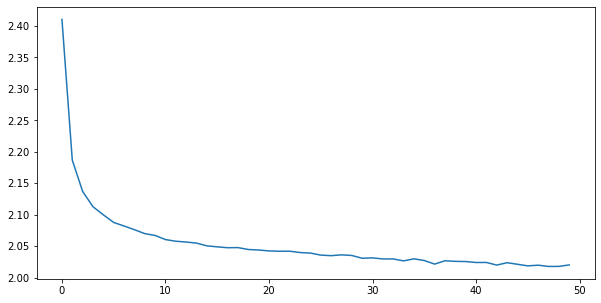

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(loss_graph)
plt.show() 

In [ ]:
criterion_many_to_many(out, y_future_test)

tensor(2.0491, grad_fn=<MeanBackward0>)

# 5. Positive Credibility 


In [ ]:
train = torch.utils.data.TensorDataset(x_current_train, lamb_future_train, y_future_train)
test = torch.utils.data.TensorDataset(x_current_test, lamb_future_test, y_future_test)

batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=True, drop_last=True )
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=True, drop_last=True )

In [ ]:
class cred_many_to_many(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers):
        super(cred_many_to_many, self).__init__()
        self.hidden_size = hidden_size # 8
        self.num_layers = num_layers # 2
        self.input_size = input_size # 10
        self.f0 = nn.Parameter(torch.ones(1),requires_grad= True )
        ########################################################################
        self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)
        # Then rnn handle the data of dimension [:, T, input_size]
        ########################################################################
        self.fc = nn.Sequential(nn.Linear(hidden_size, 1), nn.ReLU())
        
    def forward(self, y_current, lamb):
        # many-to-many
        h0 = torch.zeros(self.num_layers, y_current.shape[0], self.hidden_size) # [num_layers, n, num_hidden]
        # (num_layers, batch_size, hidden_size)

        out, hn = self.rnn(y_current, h0) # many-to-many, # out: hidden state of top layer, hn: hidden state of middle layers
        out = torch.transpose(out, 0, 1)
        out = self.fc(out) + torch.tensor(0.0001) # many-to-many (defined by matrix multiplication)
        out = torch.transpose(out, 0, 1)

        s = self.f0 + torch.cumsum(out,dim=1)

        y = y_current[:,:,0:1]
        lamb_t = y_current[:,:,1:]

        y_hat = lamb/s * ( torch.cumsum(out * y / lamb_t, dim = 1) + self.f0)

        return y_hat

In [ ]:
input_size=2
hidden_size=8
num_layers=2

model = cred_many_to_many(input_size=input_size, 
                   hidden_size=hidden_size,  
                   num_layers=num_layers)
                   
                   
def criterion_many_to_many(y_pred, y_true):
  return torch.mean((y_pred-y_true)**2)

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
ttt = model(x_current_train,lamb_future_train)
print(ttt.shape, y_future_train.shape)

torch.Size([75000, 10, 1]) torch.Size([75000, 10, 1])


In [ ]:
np.random.seed(2022)
loss_graph = []
num_epochs=30
for epoch in range(num_epochs):
    running_loss = 0.0
    n=len(train_loader)
    for seq1, seq2, target in train_loader:
    
        out = model(seq1, seq2)
        loss = criterion_many_to_many(out, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    loss_graph.append(running_loss/n)
    print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))
    
out = model(x_current_test, lamb_future_test) 

[epoch: 0] loss: 2.2822
[epoch: 1] loss: 2.2257
[epoch: 2] loss: 2.2159
[epoch: 3] loss: 2.2041
[epoch: 4] loss: 2.1945
[epoch: 5] loss: 2.1950
[epoch: 6] loss: 2.1825
[epoch: 7] loss: 2.1741
[epoch: 8] loss: 2.1713
[epoch: 9] loss: 2.1526
[epoch: 10] loss: 2.1496
[epoch: 11] loss: 2.1332
[epoch: 12] loss: 2.1413
[epoch: 13] loss: 2.1291
[epoch: 14] loss: 2.1243
[epoch: 15] loss: 2.1209
[epoch: 16] loss: 2.1269
[epoch: 17] loss: 2.1123
[epoch: 18] loss: 2.1155
[epoch: 19] loss: 2.1230
[epoch: 20] loss: 2.1099
[epoch: 21] loss: 2.1059
[epoch: 22] loss: 2.1007
[epoch: 23] loss: 2.1049
[epoch: 24] loss: 2.1013
[epoch: 25] loss: 2.0886
[epoch: 26] loss: 2.0973
[epoch: 27] loss: 2.0937
[epoch: 28] loss: 2.0843
[epoch: 29] loss: 2.0910


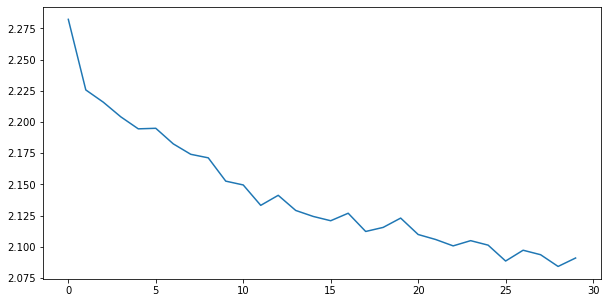

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(loss_graph)
plt.show()

In [ ]:
criterion_many_to_many(out, y_future_test)

tensor(2.1792, grad_fn=<MeanBackward0>)

### 추가 
* out 과 f0 따로 뽑아서 밖에서 계산진행해보기. 


In [ ]:
class cred_many_to_many(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers):
        super(cred_many_to_many, self).__init__()
        self.hidden_size = hidden_size # 8
        self.num_layers = num_layers # 2
        self.input_size = input_size # 10
        self.f0 = nn.Parameter(torch.ones(1),requires_grad= True )
        ########################################################################
        self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)
        # Then rnn handle the data of dimension [:, T, input_size]
        ########################################################################
        self.fc = nn.Sequential(nn.Linear(hidden_size, 1), nn.ReLU())
        
    def forward(self, y_current, lamb):
        # many-to-many
        h0 = torch.zeros(self.num_layers, y_current.shape[0], self.hidden_size) # [num_layers, n, num_hidden]
        # (num_layers, batch_size, hidden_size)

        out, hn = self.rnn(y_current, h0) # many-to-many, # out: hidden state of top layer, hn: hidden state of middle layers
        out = torch.transpose(out, 0, 1)
        out = self.fc(out) + torch.tensor(0.0001) # many-to-many (defined by matrix multiplication)
        out = torch.transpose(out, 0, 1)
        f0 = self.f0

        return f0, out

In [ ]:
input_size=2
hidden_size=8
num_layers=2

model = cred_many_to_many(input_size=input_size, 
                   hidden_size=hidden_size,  
                   num_layers=num_layers)

In [ ]:
def mypred(f0, out, y_current, lamb):

  s = f0 + torch.cumsum(out,dim=1)
  y = y_current[:,:,0:1]
  lamb_t = y_current[:,:,1:]
  y_hat = lamb/s * ( torch.cumsum(out * y / lamb_t, dim = 1) + f0)

  return y_hat 

In [ ]:
np.random.seed(2022)
loss_graph = []
num_epochs=5
for epoch in range(num_epochs):
    running_loss = 0.0
    n=len(train_loader)
    for seq1, seq2, target in train_loader:
    
        f0, out = model(seq1, seq2)
        out = mypred(f0, out, seq1, seq2)
        loss = criterion_many_to_many(out, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    loss_graph.append(running_loss/n)
    print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))

[epoch: 0] loss: 2.9748
[epoch: 1] loss: 2.9746
[epoch: 2] loss: 2.9737
[epoch: 3] loss: 2.9743
[epoch: 4] loss: 2.9748


In [ ]:
f0, out = model(x_current_test, lamb_future_test) 
out = mypred(f0, out, x_current_test, lamb_future_test)

In [ ]:
criterion_many_to_many(out, y_future_test)

tensor(3.0610, grad_fn=<MeanBackward0>)

In [ ]:
torch.sum(out<=0)

tensor(0)

전부다 positive value임을 확인할 수 있다. 

# 6. Ordered Credibility

alpha0 < alpha1 < ... < alpha{t} 


In [ ]:
class ordered_cred_many_to_many(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers):
        super(ordered_cred_many_to_many, self).__init__()
        self.hidden_size = hidden_size # 8
        self.num_layers = num_layers # 2
        self.input_size = input_size # 10
        self.f0 = nn.Parameter(torch.ones(1),requires_grad=True)
        ########################################################################
        self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)
        # Then rnn handle the data of dimension [:, T, input_size]
        ########################################################################
        self.fc = nn.Sequential(nn.Linear(hidden_size, 1), nn.ReLU())
        
    def forward(self, y_current, lamb):
        # many-to-many
        h0 = torch.zeros(self.num_layers, y_current.shape[0], self.hidden_size) # [num_layers, n, num_hidden]
        # (num_layers, batch_size, hidden_size)

        out, hn = self.rnn(y_current, h0) # many-to-many, # out: hidden state of top layer, hn: hidden state of middle layers
        out = torch.transpose(out, 0, 1)
        out = self.fc(out) + torch.tensor(0.0001) # many-to-many (defined by matrix multiplication)
        out = torch.transpose(out, 0, 1)

        out = torch.cumsum(out , dim = 1) #f 
        s = self.f0 + torch.cumsum(out, dim =1 )
        
        y = y_current[:,:,0:1]
        lamb_t = y_current[:,:,1:]

        y_hat = lamb/s * ( torch.cumsum( out * y / lamb_t, dim = 1) + self.f0)

        return y_hat

In [ ]:
input_size=2
hidden_size=8
num_layers=2

model = ordered_cred_many_to_many(input_size=input_size, 
                   hidden_size=hidden_size,  
                   num_layers=num_layers)
                   
                   
def criterion_many_to_many(y_pred, y_true):
  return torch.mean((y_pred-y_true)**2)

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
np.random.seed(2022)
loss_graph = []
num_epochs=30
for epoch in range(num_epochs):
    running_loss = 0.0
    n=len(train_loader)
    for seq1, seq2, target in train_loader:
    
        out = model(seq1, seq2)
        loss = criterion_many_to_many(out, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    loss_graph.append(running_loss/n)
    print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))
    
out = model(x_current_test, lamb_future_test) 

[epoch: 0] loss: 3.0763
[epoch: 1] loss: 3.3628
[epoch: 2] loss: 3.3554
[epoch: 3] loss: 3.3370
[epoch: 4] loss: 3.3016
[epoch: 5] loss: 3.2585
[epoch: 6] loss: 3.2197
[epoch: 7] loss: 3.1899
[epoch: 8] loss: 3.1701
[epoch: 9] loss: 3.1544
[epoch: 10] loss: 3.1449
[epoch: 11] loss: 3.1384
[epoch: 12] loss: 3.1342
[epoch: 13] loss: 3.1311
[epoch: 14] loss: 3.1294
[epoch: 15] loss: 3.1279
[epoch: 16] loss: 3.1272
[epoch: 17] loss: 3.1266
[epoch: 18] loss: 3.1263
[epoch: 19] loss: 3.1268
[epoch: 20] loss: 3.1257
[epoch: 21] loss: 3.1255
[epoch: 22] loss: 3.1254
[epoch: 23] loss: 3.1254
[epoch: 24] loss: 3.1255
[epoch: 25] loss: 3.1252
[epoch: 26] loss: 3.1254
[epoch: 27] loss: 3.1253
[epoch: 28] loss: 3.1251
[epoch: 29] loss: 3.1251


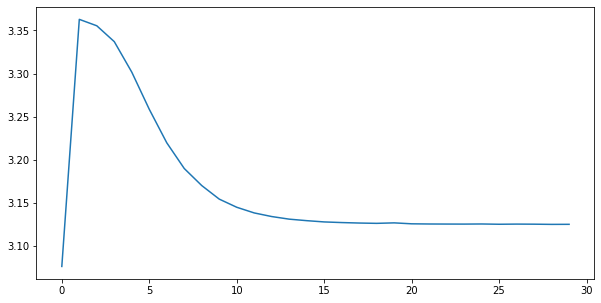

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(loss_graph)
plt.show()

In [ ]:
criterion_many_to_many(out, y_future_test)

tensor(3.2198, grad_fn=<MeanBackward0>)

### 추가 : Ordered? 


In [ ]:
class ordered_out(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers):
        super(ordered_out, self).__init__()
        self.hidden_size = hidden_size # 8
        self.num_layers = num_layers # 2
        self.input_size = input_size # 10
        self.f0 = nn.Parameter(torch.ones(1),requires_grad=True)
        ########################################################################
        self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)
        # Then rnn handle the data of dimension [:, T, input_size]
        ########################################################################
        self.fc = nn.Sequential(nn.Linear(hidden_size, 1), nn.ReLU())
        
    def forward(self, y_current, lamb):
        # many-to-many
        h0 = torch.zeros(self.num_layers, y_current.shape[0], self.hidden_size) # [num_layers, n, num_hidden]
        # (num_layers, batch_size, hidden_size)

        out, hn = self.rnn(y_current, h0) # many-to-many, # out: hidden state of top layer, hn: hidden state of middle layers
        out = torch.transpose(out, 0, 1)
        out = self.fc(out) + torch.tensor(0.0001) # many-to-many (defined by matrix multiplication)
        out = torch.transpose(out, 0, 1)

        out = torch.cumsum(out , dim = 1) #f 

        return out

In [ ]:
input_size=2
hidden_size=8
num_layers=2

model = ordered_out(input_size=input_size, 
                   hidden_size=hidden_size,  
                   num_layers=num_layers)
                   

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
def mypred(out, y_current, lamb):

  f0 = torch.tensor(1.0,requires_grad=True)
  s = f0 + torch.cumsum(out,dim=1)
  y = y_current[:,:,0:1]
  lamb_t = y_current[:,:,1:]
  y_hat = lamb/s * ( torch.cumsum(out * y / lamb_t, dim = 1) + f0)

  return y_hat 

In [ ]:
np.random.seed(2022)
loss_graph = []
num_epochs=5

for epoch in range(num_epochs):
    running_loss = 0.0
    n=len(train_loader)
    for seq1, seq2, target in train_loader:
    
        out = model(seq1, seq2)
        out = mypred(out, seq1, seq2)
        loss = criterion_many_to_many(out, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    loss_graph.append(running_loss/n)
    print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))
    
out = model(x_current_test, lamb_future_test) 

[epoch: 0] loss: 2.3557
[epoch: 1] loss: 2.3354
[epoch: 2] loss: 2.3175
[epoch: 3] loss: 2.3072
[epoch: 4] loss: 2.3048


In [ ]:
out.shape

torch.Size([60000, 10, 1])

In [ ]:
y_hat = mypred(out, x_current_test, lamb_future_test)
loss = criterion_many_to_many(y_hat, y_future_test)

In [ ]:
loss

tensor(2.3424, grad_fn=<MeanBackward0>)

In [ ]:
out[0,:,:]

tensor([[0.1828],
        [0.1829],
        [0.1830],
        [0.1831],
        [0.1832],
        [0.1833],
        [0.1834],
        [0.1835],
        [0.3166],
        [0.3167]], grad_fn=<SliceBackward0>)

Output value가 정확히 ordered 된 것을 확인할 수 있다. 